# OverNight Stock Returns Predictions --- Linear Regression

Since we are going to mostly work with classification problems, I thought it might be a good idea to work with a continuous variable in this assignment. For this assignment we are going to work with the following dataset, which contains daily data on U.S. stock prices.

https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs

Use this data to build a model to predict stock prices. Which stock? Anyone that you like. Define your own Y variable. Following are some examples, but you don't have to follow these:

    Daily Price of a single stock (your choice)
    Or average weekly price of Market (for example S&P500)
    Or price of a portfolio of your choice (a group of stocks) every Monday. 
    For example, your portfolio might be 10 stocks with highest price (they might be overpriced).
    
To define the Y variable, you may want to use guidelines and theories that you have learned in the program. Basically a trader is always looking for stocks that are over-priced (under-priced) to sell (buy).

Regarding X variables (independent variables) again use your judgment. You may want to use lag of prices, volume, lag of market price, lag of price of similar stocks (portfolios), average prices in the last one week, maximum price in the last one month, variance of price, ... Define as many X variables as you want.

    Using this data build a predictive linear model. Build the model in three ways:
    Using sklearn (LinearRegression)
    Using StatsModels --- What differences you see between sklearn and StatsModels
    Using your own Least Square function. For this option write a function that gets Y and X data as input and minimizes the Squared Errors. Use Scipy package for the optimization. Does your optimization function give you the same model as models you got from sklearn or StatsModels? Try a few alternative optimization methods.
    
Use your model, to come up with a trading strategy and calculate the return on your strategy.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
# import matplotlib.pyplot as plt
from pylab import plt
plt.style.use('seaborn')
plt.rcParams['font.family'] = 'serif'
%matplotlib inline

In [2]:
def get_prices(start, end):
    file_location = input("Please choose 'Stocks' or 'ETFs': ")
    ticker = input("Please choose ticker: ")
    df = pd.read_csv('{}\{}.us.txt'.format(file_location, ticker), index_col= 0, parse_dates= True)
    df.drop(["OpenInt"],axis = 1,inplace=True) # Drop Open interest since we are not dealing with derivative prices. 
    df = df.loc[start:end] #customized start and end date. Will give error if date range not in dataset.
    return df

In [3]:
asset = get_prices('2016-01-01','2016-12-31') #choose 1 year intervals}
benchmark =  get_prices('2016-01-01','2016-12-31') 
Rf_bench =  get_prices('2016-01-01','2016-12-31') 

Please choose 'Stocks' or 'ETFs': Stocks
Please choose ticker: tsla
Please choose 'Stocks' or 'ETFs': ETFs
Please choose ticker: spy
Please choose 'Stocks' or 'ETFs': ETFs
Please choose ticker: bil


In [4]:
asset = asset.copy()

### Function that returns back predicting variables and the respone variables

   The response / dependent variable " $y$ " is the overnight return (ie log(Price Next Day's Open / Price of Previous Day Close)).

In [5]:
def feature_eng(df):
    df['VWAP'] = (df.Volume*(df.Close)).cumsum() / df.Volume.cumsum()
    
#     df['EWMA21'] = df['Close'].ewm(span=21,adjust=False).mean()
#     df['EWMA252'] = df['Close'].ewm(span=252,adjust=False).mean()
#     df['SMA21'] = df['Close'].rolling(window=21).mean()
#     df['MAD'] = df['Close'].rolling(window=21).mean()/ df['Close'].rolling(window=252).mean().iloc[len(df['SMA21'])-1:].values[0]
    df['EWMAD'] = df['Close'].ewm(span=21,adjust=False).mean() / df['Close'].ewm(span=252,adjust=False).mean()
    df['SMAD'] = df['Close'].shift(1).rolling(window=3).mean() / df['Close'].shift(1).rolling(window=15).mean()
    df['Open-Close'] = df.Open - df.Close
#     df['SMA3'] = df['Close'].shift(1).rolling(window=3).mean()
#     df['SMA15']= df['Close'].shift(1).rolling(window=15).mean()
    df['Corr']=df['Close'].shift(1).rolling(window=10).corr(df['Close'].shift(1).rolling(window=3).mean())
#     df['ClosingReturns'] = df['Close'].pct_change(1)
    df["CLogreturn"] = np.log(df['Close']/ df['Close'].shift(1))
    df['High-Low'] = df.High - df.Low
    df['Close_Signal'] = np.where(df['Close'] > df['Close'].shift(1),1,-1)
    df['Open_Close_Signal'] = np.where(df['Open-Close'] > df['Open-Close'].shift(1),1,-1)
    df['High_Low_Signal']= np.where(df['High-Low'] > df['High-Low'].shift(1),1,-1)
    df['VWAP_Signal']= np.where(df['VWAP'] > df['Close'],1,-1)
    df['VWAP_Signal_2']= np.where(df['VWAP'] > df['VWAP'].shift(1),1,-1)
    df['ONReturns_y']= np.log(df['Open'].shift(-1)/df['Close']) #shift(1) the future next day open price
#     df.drop(['Open', 'High', 'Low', 'Close', 'Volume','Open-Close', 'High-Low'], axis = 1,inplace=True)
    return df

In [6]:
stock = feature_eng(asset)
spy = feature_eng(benchmark)
tbill = feature_eng(Rf_bench)


The respectuve returns of the ETFs that track the S&P500 ($SPY$) and 3-month T-Bills ($BIL$) are added to the stock&nbsp;&nbsp;&nbsp;&nbsp;<tt>Dataframe</tt>. 


In [7]:
#Prevent looahead bias--Shift these predictors 1 period
stock['Rmrkt'] = spy['CLogreturn'].shift(1) #Daily returns a day before
stock['Rfree'] = tbill['CLogreturn'].shift(1)#Daily returns a day before
stock['ON-Rm'] = spy['ONReturns_y'].shift(1) #Overnight returns a day before
stock['ON-Rf'] = tbill['ONReturns_y'].shift(1)


In [8]:
stock.dropna(inplace=True)
stock.head()
    

,Open,High,Low,Close,Volume,VWAP,EWMAD,SMAD,Open-Close,Corr,...,Close_Signal,Open_Close_Signal,High_Low_Signal,VWAP_Signal,VWAP_Signal_2,ONReturns_y,Rmrkt,Rfree,ON-Rm,ON-Rf
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-26,196.70,197.82,188.88,193.56,4123942,207.690707,0.940025,0.958488,3.14,0.799928,...,-1,-1,1,1,-1,-0.006115,-0.015233,0.00022,0.004133,0.00000
2016-01-27,192.38,193.26,185.77,188.07,3530660,206.633802,0.932882,0.957376,4.31,0.850442,...,-1,1,-1,1,-1,0.014359,0.013491,-0.00022,-0.003110,0.00022
2016-01-28,190.79,191.28,182.41,189.70,3867413,205.690300,0.927083,0.944775,1.09,0.887985,...,1,-1,1,1,-1,0.001317,-0.010900,0.00022,0.009646,-0.00022
2016-01-29,189.95,193.74,188.08,191.11,2244637,205.233571,0.922421,0.942916,-1.16,0.939562,...,1,-1,-1,1,-1,-0.012373,0.005328,0.00000,0.004645,-0.00022
2016-02-01,188.76,199.52,182.75,196.94,4572522,204.736088,0.920466,0.946540,-8.18,0.915552,...,1,-1,1,1,-1,-0.023219,0.024031,0.00022,-0.006223,-0.00022


### Apply Granger Causality Tests (4 statistical tests on time series):

The Null hypothesis $H_0$ for grangercausalitytests is that the time series in the second column, x2 ($X$), does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1 ($y$), taking past values of x1 into account as regressors. We reject the null hypothesisthat x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [9]:
from statsmodels.tsa.stattools import grangercausalitytests
#[y,x]
for i in stock.columns.drop('ONReturns_y'):
    print("\n\t\t\t::::",i, "::::")
    grangercausalitytests(stock[['ONReturns_y',i]],maxlag=7);
    print("End of casuality test between {} and the dependent variable!".format(i))


			:::: Open ::::

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6216  , p=0.2041  , df_denom=232, df_num=1
ssr based chi2 test:   chi2=1.6426  , p=0.2000  , df=1
likelihood ratio test: chi2=1.6369  , p=0.2008  , df=1
parameter F test:         F=1.6216  , p=0.2041  , df_denom=232, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7555  , p=0.4709  , df_denom=229, df_num=2
ssr based chi2 test:   chi2=1.5440  , p=0.4621  , df=2
likelihood ratio test: chi2=1.5389  , p=0.4633  , df=2
parameter F test:         F=0.7555  , p=0.4709  , df_denom=229, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5499  , p=0.6487  , df_denom=226, df_num=3
ssr based chi2 test:   chi2=1.7007  , p=0.6368  , df=3
likelihood ratio test: chi2=1.6946  , p=0.6381  , df=3
parameter F test:         F=0.5499  , p=0.6487  , df_denom=226, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0

parameter F test:         F=1.6584  , p=0.1607  , df_denom=223, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.6806  , p=0.1403  , df_denom=220, df_num=5
ssr based chi2 test:   chi2=8.8232  , p=0.1163  , df=5
likelihood ratio test: chi2=8.6588  , p=0.1235  , df=5
parameter F test:         F=1.6806  , p=0.1403  , df_denom=220, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=1.8233  , p=0.0957  , df_denom=217, df_num=6
ssr based chi2 test:   chi2=11.5954 , p=0.0716  , df=6
likelihood ratio test: chi2=11.3126 , p=0.0792  , df=6
parameter F test:         F=1.8233  , p=0.0957  , df_denom=217, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.4746  , p=0.0184  , df_denom=214, df_num=7
ssr based chi2 test:   chi2=18.5363 , p=0.0098  , df=7
likelihood ratio test: chi2=17.8243 , p=0.0128  , df=7
parameter F test:         F=2.4746  , p=0.0184  , df_denom=214, df_num=7
End of casuality test

ssr based F test:         F=0.5902  , p=0.7380  , df_denom=217, df_num=6
ssr based chi2 test:   chi2=3.7534  , p=0.7100  , df=6
likelihood ratio test: chi2=3.7231  , p=0.7141  , df=6
parameter F test:         F=0.5902  , p=0.7380  , df_denom=217, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5364  , p=0.8064  , df_denom=214, df_num=7
ssr based chi2 test:   chi2=4.0179  , p=0.7777  , df=7
likelihood ratio test: chi2=3.9830  , p=0.7817  , df=7
parameter F test:         F=0.5364  , p=0.8064  , df_denom=214, df_num=7
End of casuality test between Corr and the dependent variable!

			:::: CLogreturn ::::

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6897  , p=0.4071  , df_denom=232, df_num=1
ssr based chi2 test:   chi2=0.6986  , p=0.4032  , df=1
likelihood ratio test: chi2=0.6976  , p=0.4036  , df=1
parameter F test:         F=0.6897  , p=0.4071  , df_denom=232, df_num=1

Granger Causality
number of lags (no zero) 2
ssr ba

parameter F test:         F=0.5881  , p=0.7091  , df_denom=220, df_num=5

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=0.7929  , p=0.5764  , df_denom=217, df_num=6
ssr based chi2 test:   chi2=5.0421  , p=0.5384  , df=6
likelihood ratio test: chi2=4.9876  , p=0.5454  , df=6
parameter F test:         F=0.7929  , p=0.5764  , df_denom=217, df_num=6

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.6811  , p=0.6880  , df_denom=214, df_num=7
ssr based chi2 test:   chi2=5.1021  , p=0.6475  , df=7
likelihood ratio test: chi2=5.0461  , p=0.6543  , df=7
parameter F test:         F=0.6811  , p=0.6880  , df_denom=214, df_num=7
End of casuality test between Open_Close_Signal and the dependent variable!

			:::: High_Low_Signal ::::

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1822  , p=0.6699  , df_denom=232, df_num=1
ssr based chi2 test:   chi2=0.1846  , p=0.6675  , df=1
likelihood ratio test: chi2=0.1845  , p=0.6

ssr based F test:         F=0.2332  , p=0.7922  , df_denom=229, df_num=2
ssr based chi2 test:   chi2=0.4766  , p=0.7880  , df=2
likelihood ratio test: chi2=0.4761  , p=0.7882  , df=2
parameter F test:         F=0.2332  , p=0.7922  , df_denom=229, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1484  , p=0.9306  , df_denom=226, df_num=3
ssr based chi2 test:   chi2=0.4590  , p=0.9278  , df=3
likelihood ratio test: chi2=0.4586  , p=0.9279  , df=3
parameter F test:         F=0.1484  , p=0.9306  , df_denom=226, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.5309  , p=0.7132  , df_denom=223, df_num=4
ssr based chi2 test:   chi2=2.2093  , p=0.6973  , df=4
likelihood ratio test: chi2=2.1988  , p=0.6992  , df=4
parameter F test:         F=0.5309  , p=0.7132  , df_denom=223, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=0.4978  , p=0.7777  , df_denom=220, df_num=5
ssr based chi2 test: 

#### After running the causality test, check for very low p-values(<0.01) to reject null that a lag in the tested variable causes the change in our dependent(response) variable. This test gives different outcomes for diffrernt chosen stocks. Thus manuel input of the column/s is need to $.shift()$ them by the required number of significant lags.

In [11]:
variable = input("Please input column name that has low p_value after number of lags passed: ")
lag = int(input("Please state the number of lags: "))

Please input column name that has low p_value after number of lags passed: ON-Rm
Please state the number of lags: 3


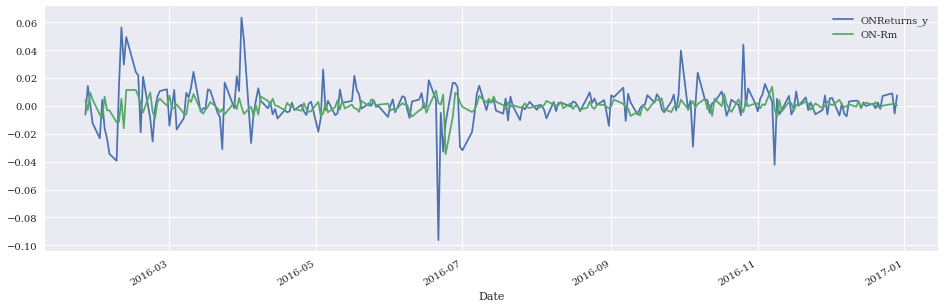

In [12]:
stock[['ONReturns_y',variable]].plot(figsize=(16,5)); #Before lags

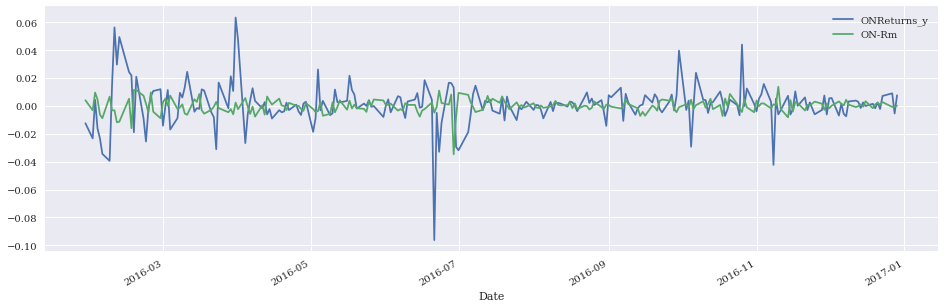

In [13]:
stock['ONReturns_y'].iloc[lag:].plot(figsize=(16,5),legend=True);
stock[variable].shift(lag).plot(legend=True);

In [14]:
stock[variable] = stock[variable].shift(lag)

In [15]:
stock.head(10)

,Open,High,Low,Close,Volume,VWAP,EWMAD,SMAD,Open-Close,Corr,...,Close_Signal,Open_Close_Signal,High_Low_Signal,VWAP_Signal,VWAP_Signal_2,ONReturns_y,Rmrkt,Rfree,ON-Rm,ON-Rf
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-26,196.700,197.82,188.880,193.56,4123942,207.690707,0.940025,0.958488,3.140,0.799928,...,-1,-1,1,1,-1,-0.006115,-0.015233,0.00022,NaN,0.00000
2016-01-27,192.380,193.26,185.770,188.07,3530660,206.633802,0.932882,0.957376,4.310,0.850442,...,-1,1,-1,1,-1,0.014359,0.013491,-0.00022,NaN,0.00022
2016-01-28,190.790,191.28,182.410,189.70,3867413,205.690300,0.927083,0.944775,1.090,0.887985,...,1,-1,1,1,-1,0.001317,-0.010900,0.00022,NaN,-0.00022
2016-01-29,189.950,193.74,188.080,191.11,2244637,205.233571,0.922421,0.942916,-1.160,0.939562,...,1,-1,-1,1,-1,-0.012373,0.005328,0.00000,0.004133,-0.00022
2016-02-01,188.760,199.52,182.750,196.94,4572522,204.736088,0.920466,0.946540,-8.180,0.915552,...,1,-1,1,1,-1,-0.023219,0.024031,0.00022,-0.003110,-0.00022
2016-02-02,192.420,193.12,180.230,182.78,4994163,203.386072,0.913373,0.965817,9.640,0.851883,...,-1,1,-1,1,-1,0.004422,-0.000374,-0.00044,0.009646,0.00000
2016-02-03,183.590,183.94,170.180,173.48,6766212,201.086348,0.903468,0.962315,10.110,0.804361,...,-1,1,1,1,-1,-0.016155,-0.018303,0.00000,0.004645,0.00022
2016-02-04,170.700,175.98,166.990,175.33,3697860,200.047560,0.895266,0.944211,-4.630,0.874663,...,1,-1,-1,1,-1,-0.023254,0.006084,0.00022,-0.006223,0.00000
2016-02-05,171.300,173.00,157.744,162.60,8856904,196.748809,0.883030,0.915130,8.700,0.881691,...,-1,1,1,1,-1,-0.034379,0.001569,0.00022,-0.008759,0.00000


In [16]:
stock.drop(['Open', 'High', 'Low', 'Close', 'Volume','Open-Close', 'High-Low', 'VWAP'], axis = 1,inplace=True)

In [17]:
stock.dropna(inplace=True)
stock.head()

,EWMAD,SMAD,Corr,CLogreturn,Close_Signal,Open_Close_Signal,High_Low_Signal,VWAP_Signal,VWAP_Signal_2,ONReturns_y,Rmrkt,Rfree,ON-Rm,ON-Rf
Date,,,,,,,,,,,,,,
2016-01-29,0.922421,0.942916,0.939562,0.007405,1,-1,-1,1,-1,-0.012373,0.005328,0.00000,0.004133,-0.00022
2016-02-01,0.920466,0.946540,0.915552,0.030050,1,-1,1,1,-1,-0.023219,0.024031,0.00022,-0.003110,-0.00022
2016-02-02,0.913373,0.965817,0.851883,-0.074616,-1,1,-1,1,-1,0.004422,-0.000374,-0.00044,0.009646,0.00000
2016-02-03,0.903468,0.962315,0.804361,-0.052221,-1,1,1,1,-1,-0.016155,-0.018303,0.00000,0.004645,0.00022
2016-02-04,0.895266,0.944211,0.874663,0.010608,1,-1,-1,1,-1,-0.023254,0.006084,0.00022,-0.006223,0.00000


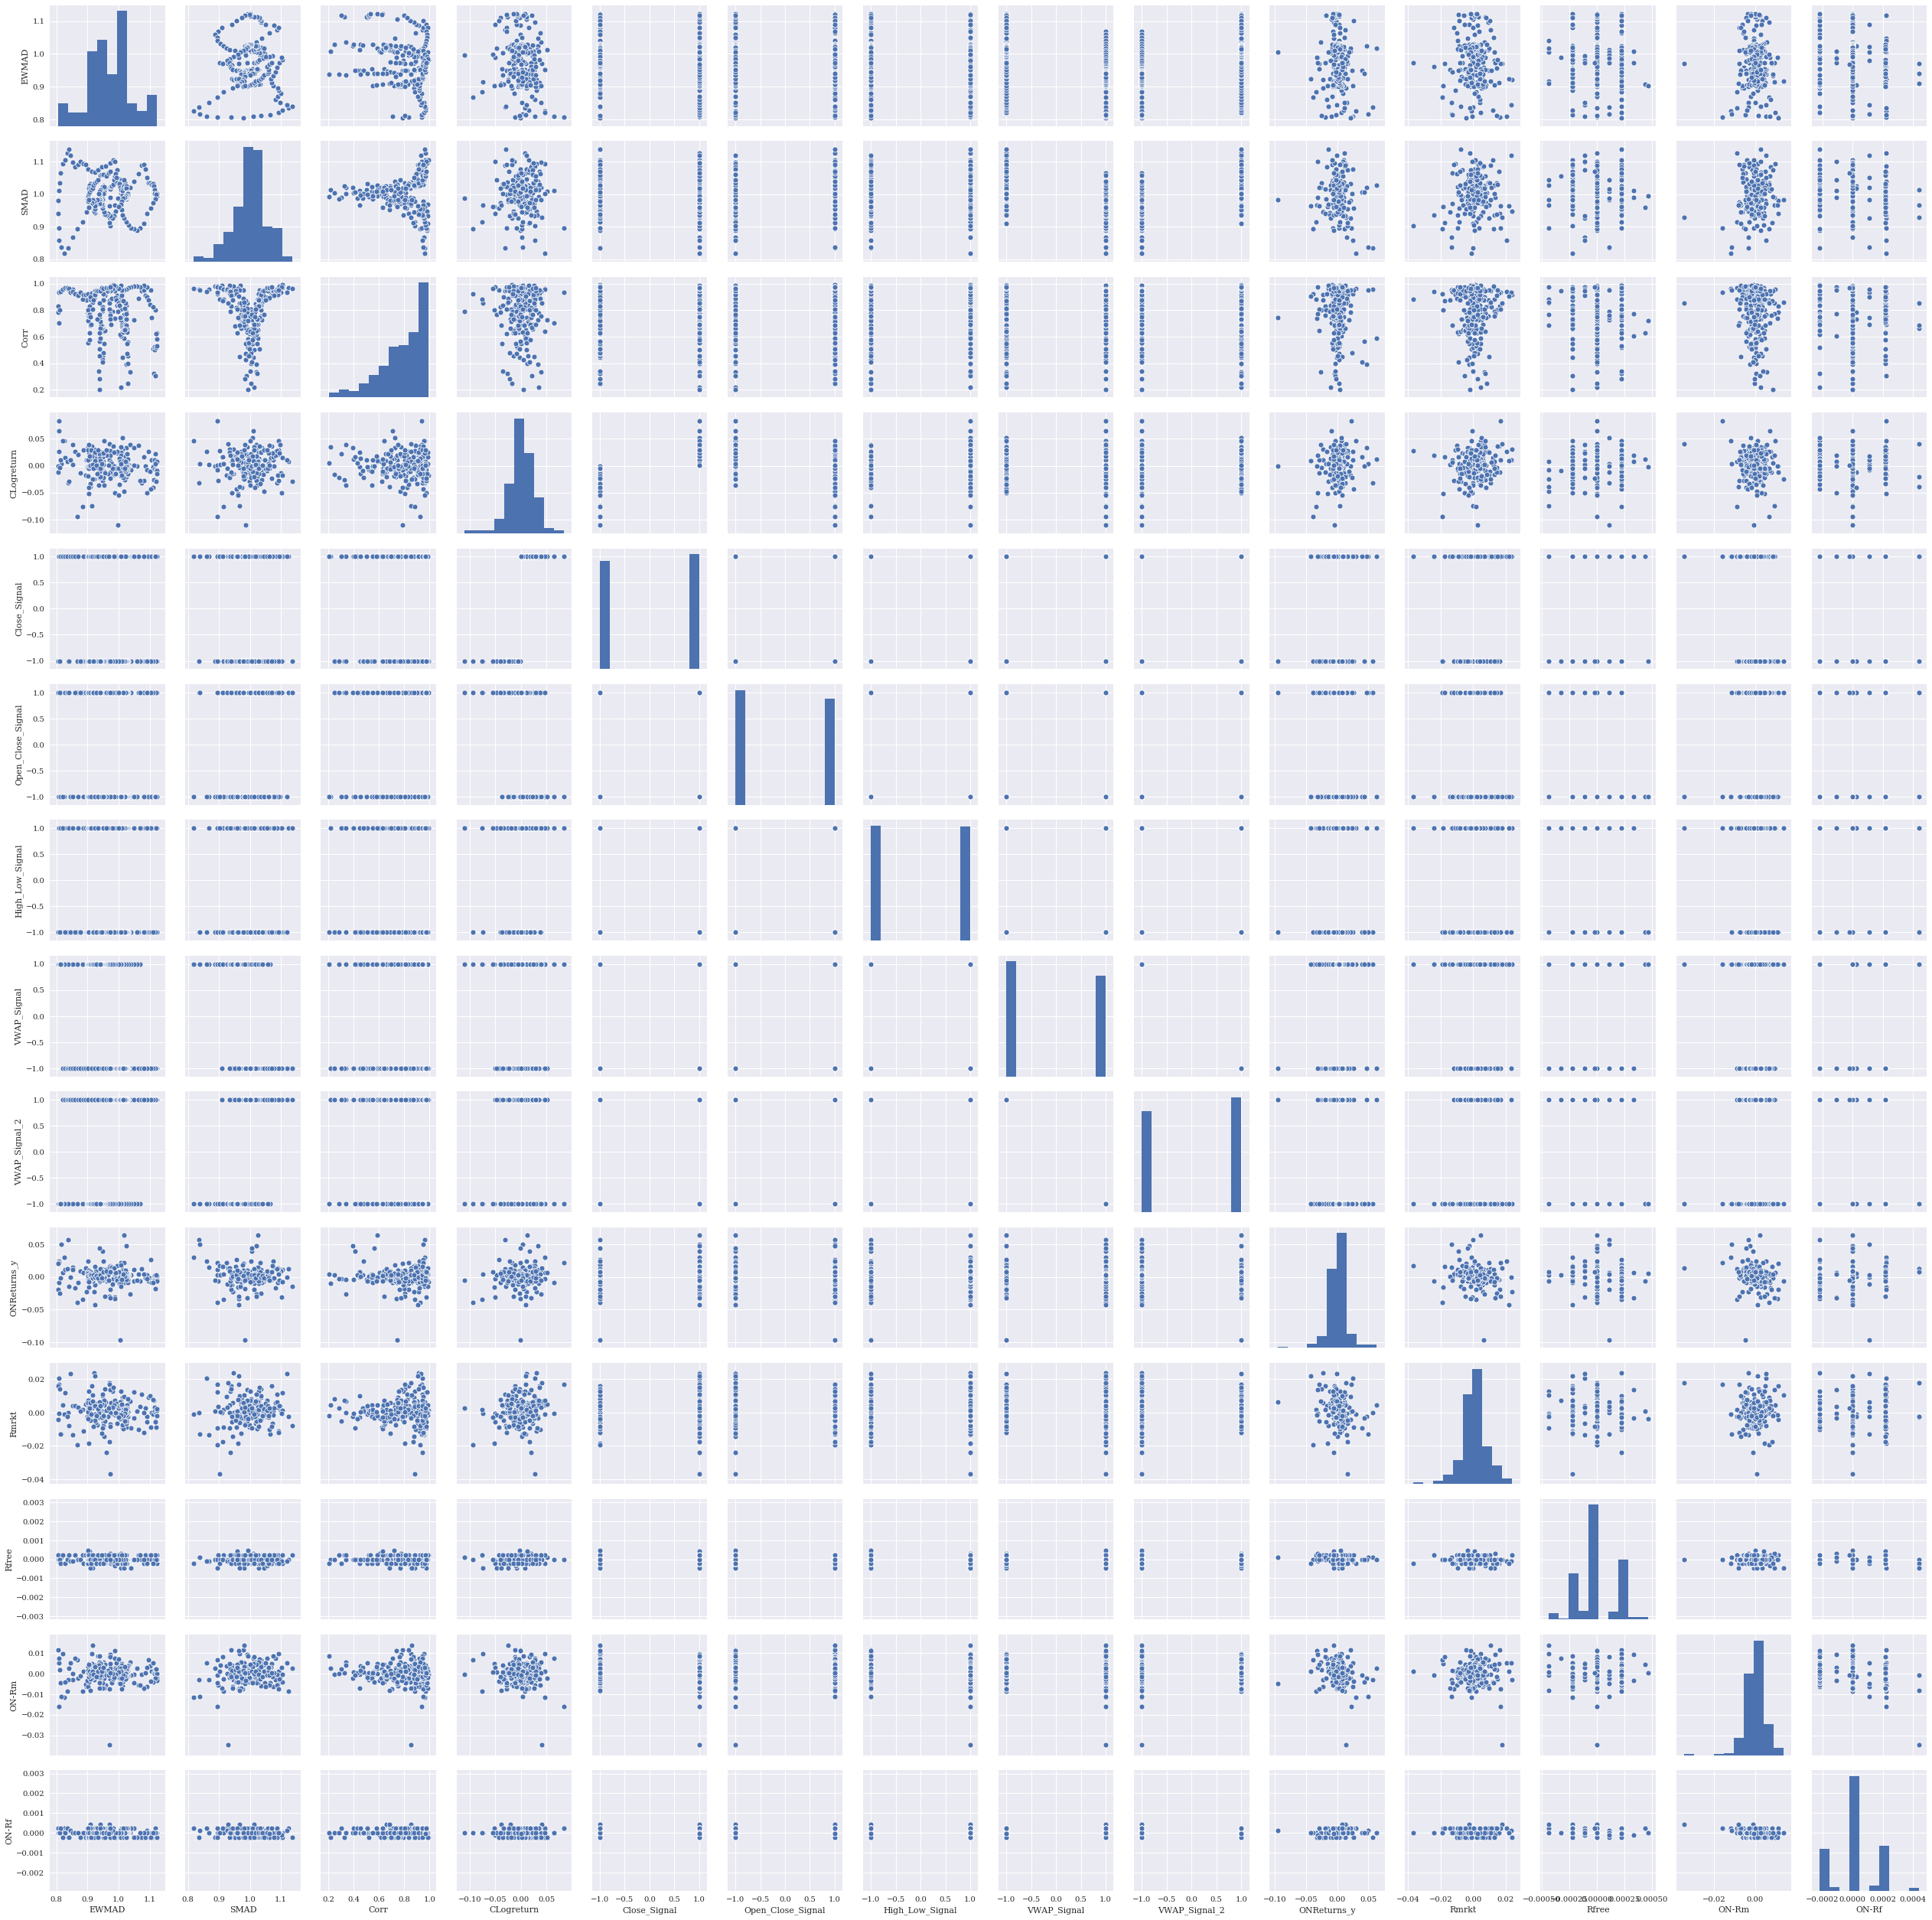

In [18]:
sns.pairplot(stock);

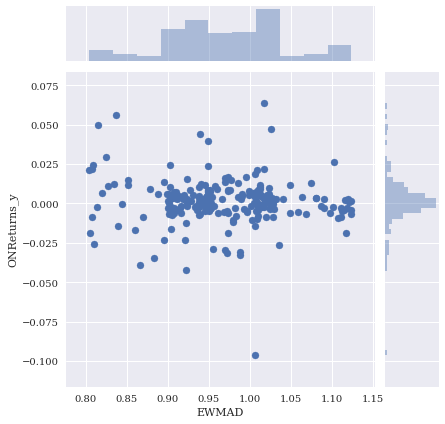

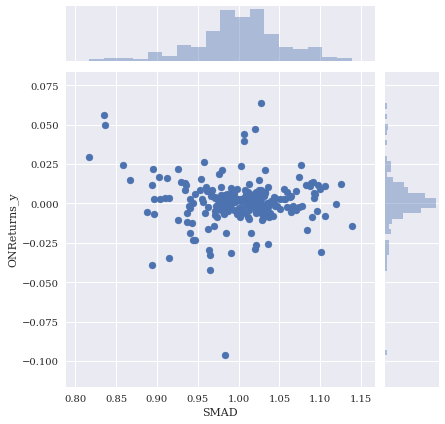

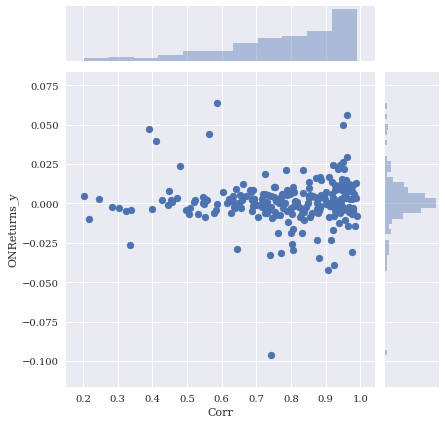

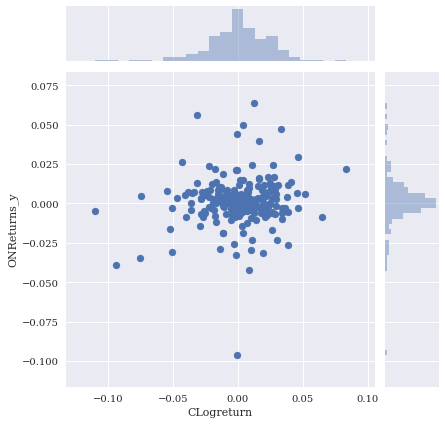

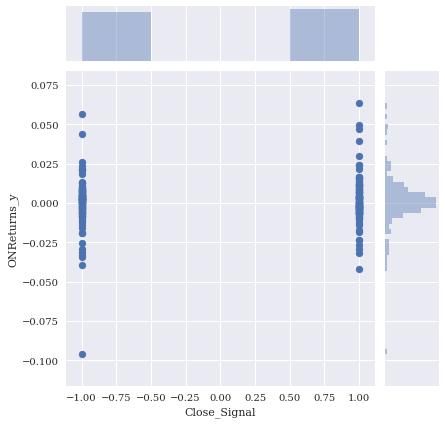

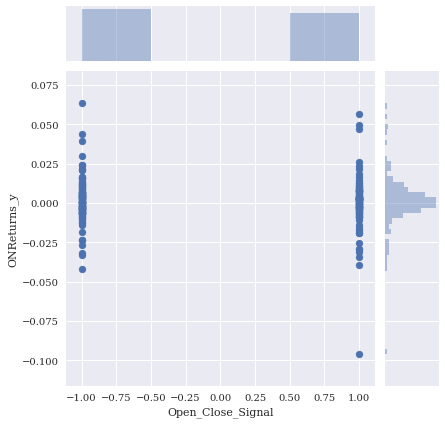

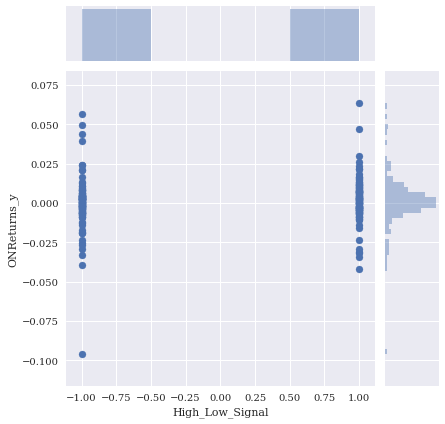

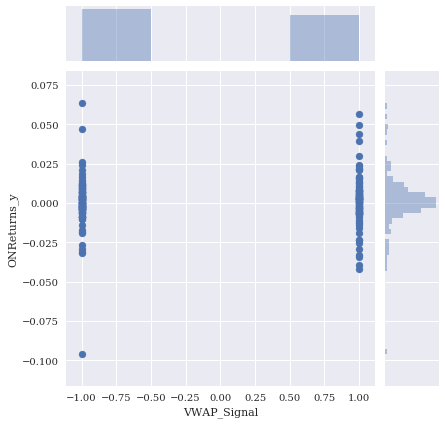

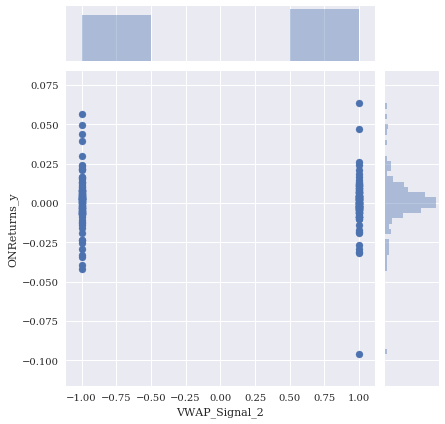

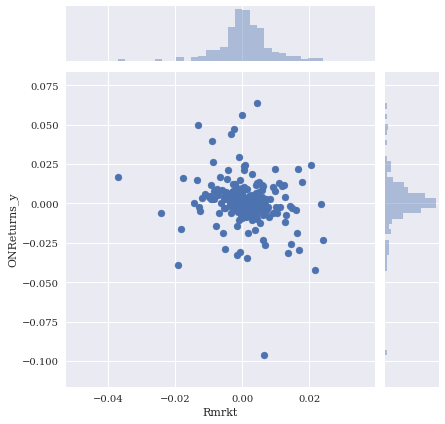

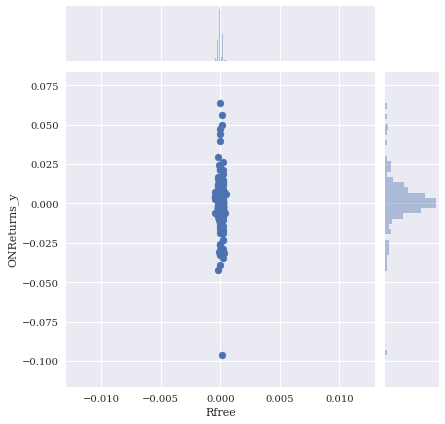

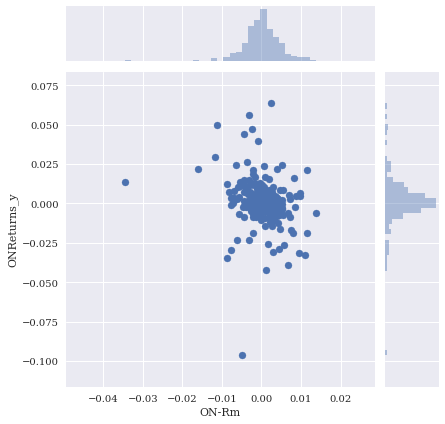

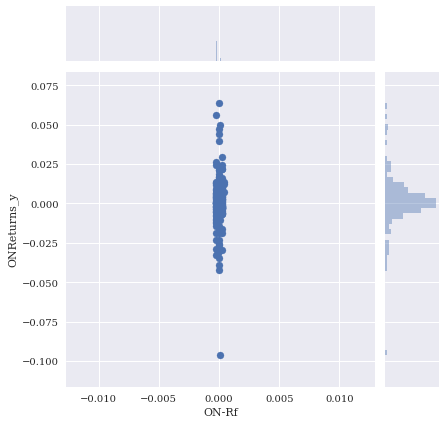

In [19]:
for i in stock.columns.drop('ONReturns_y'):
    sns.jointplot(x=i,y='ONReturns_y',data=stock);

In [20]:
stock.drop('ON-Rf', axis = 1, inplace = True)
stock.drop('Rfree', axis = 1, inplace = True)

## SKLearn (Linear Regression):

In [21]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
def mlr_sklearn(df, response):
    X = df.drop(response, axis = 1)
    y = df[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
    scaler = StandardScaler()
    scaler.fit(X_train)
    sel_ = SelectFromModel(LinearRegression())
    sel_.fit(scaler.transform(X_train), y_train)
    selected_feat = X_train.columns[(sel_.get_support())]
    X_new = df[selected_feat]
    X_new_train, X_new_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=101)
    lm = LinearRegression() #features only scled for feature selection not for fitting in the model
    lm.fit(X_new_train,y_train)
    coeff_df = pd.DataFrame(lm.coef_,X_new.columns,columns=['Coefficient'])
    predictions = lm.predict(X_new_test)
    predic_plot = plt.scatter(y_test,predictions)
    print('MAE:', metrics.mean_absolute_error(y_test, predictions))
    print('MSE:', metrics.mean_squared_error(y_test, predictions))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
    print("R-Square:", metrics.r2_score(y_test, predictions))
    print('total features: {}'.format((X_train.shape[1])))
    print('selected features: {}'.format(len(selected_feat)))
    print('features with coefficients greater than the mean coefficient: {}'.format(
        np.sum(np.abs(sel_.estimator_.coef_) > np.abs(sel_.estimator_.coef_).mean())))
    return coeff_df, selected_feat, lm, X_new_test, y_test

MAE: 0.009331133054063467
MSE: 0.00021571479129861253
RMSE: 0.014687232254533614
R-Square: -0.012689629933048563
total features: 11
selected features: 5
features with coefficients greater than the mean coefficient: 5


,Coefficient
EWMAD,-0.018110
SMAD,-0.019100
CLogreturn,0.067673
Rmrkt,-0.441447
ON-Rm,-0.702519


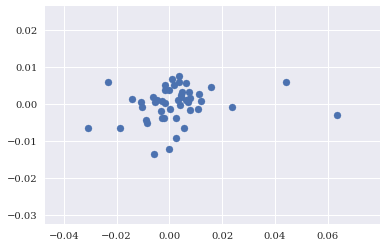

In [22]:
results,features, model, X_new_test, y_test = mlr_sklearn(stock, 'ONReturns_y')
results

Selecting features by the mean of the regression coefficients might not be the best choice as results are not that appealing in terms of $R^2$.

## Statsmodel (Regression):

In [23]:
import statsmodels.api as sm
# If the observations are in a dataframe, you can use statsmodels.formulas.api to do the regression instead
from statsmodels import regression
def mlr_statsmodel(features, df,response):
    X = df[features]
    y = df[response]
    mlr = regression.linear_model.OLS(y, sm.add_constant(X)).fit()
    fig = plt.figure(figsize=(20,12))
    fig = sm.graphics.plot_partregress_grid(mlr, fig=fig)
    return mlr.summary()

    
    

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            ONReturns_y   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.087
Method:                 Least Squares   F-statistic:                     5.447
Date:                Mon, 09 Sep 2019   Prob (F-statistic):           9.38e-05
Time:                        14:02:50   Log-Likelihood:                 662.47
No. Observations:                 233   AIC:                            -1313.
Df Residuals:                     227   BIC:                            -1292.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0312      0.021      1.451      0.148      -0.011       0.073
EWMAD         -0.0185      0.013     -1.398      0.163      -0.045       0.008
SMAD          -0.0118      0.018     -0.656      0.512      -0.047       0.024
CLogreturn     0.0674      0.039      1.707      0.089      -0.010       0.145
Rmrkt         -0.4080      0.126     -3.230      0.001      -0.657      -0.159
ON-Rm         -0.6495      0.199     -3.269      0.001      -1.041      -0.258
==============================================================================
Omnibus:                       83.362   Durbin-Watson:                   1.689
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1440.327
Skew:                          -0.879   Prob(JB):                         0.00
Kurtosis:                      15.053   Cond. No.                         365.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

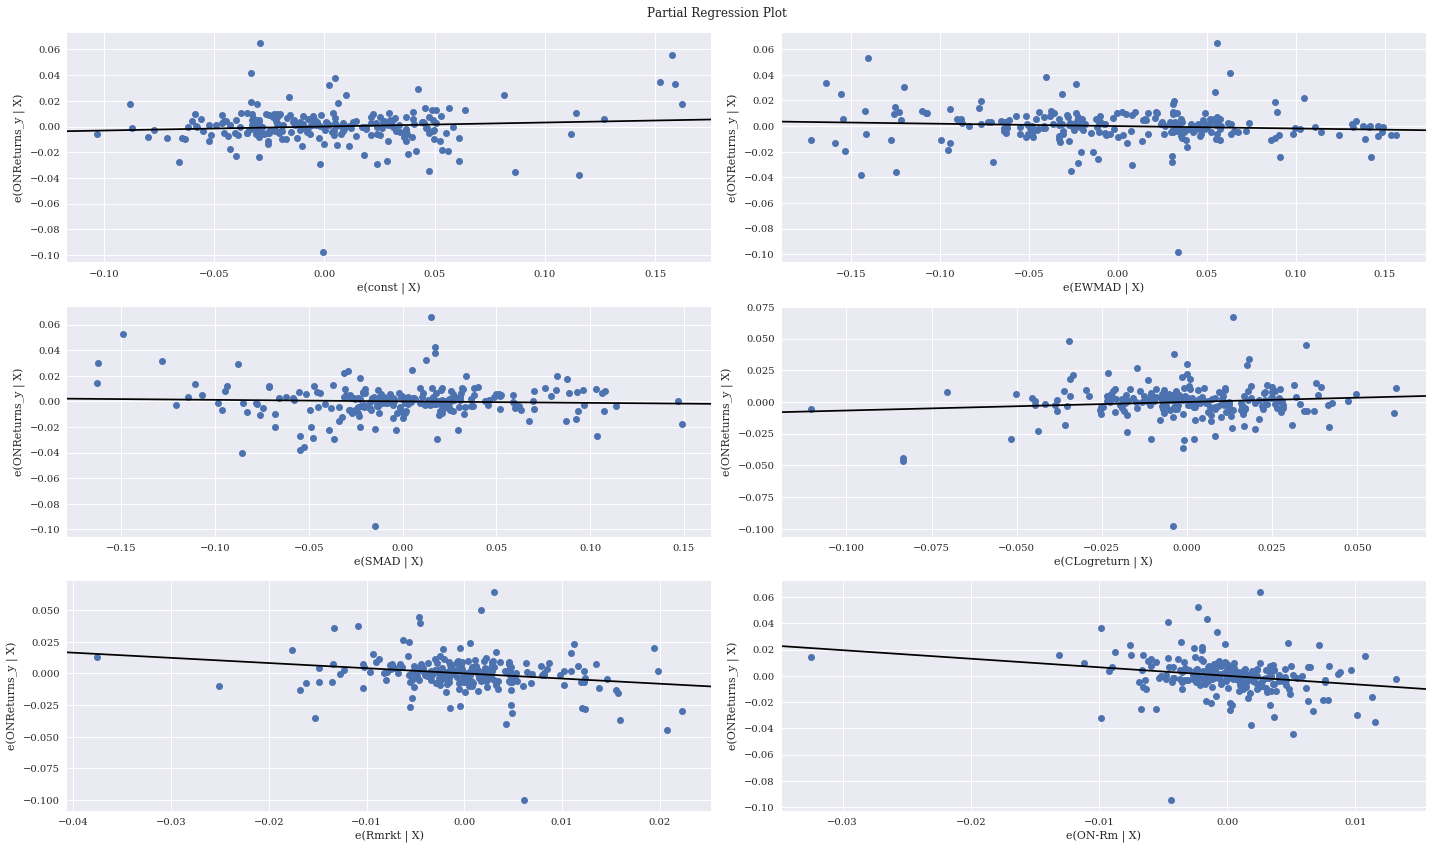

In [24]:
mlr_statsmodel(features, stock, 'ONReturns_y')


In [25]:
# the LinearRegression object from sklearn is a non-regularised
# linear method. It fits by matrix multiplication and not 
# gradient descent as in statsmodel case.

## Linear Least Squares Fit:

$beta$ = $inv(X^T.dot(X)).dot(X^T).dot(y)$

In [26]:
from numpy.linalg import inv
X = np.array(stock[features].values)
y = np.array(stock['ONReturns_y'].values)
M=np.column_stack((np.ones(len(X)),X)) # add ones column for the intercept
MTM= np.dot(M.transpose(),M)
MTMinv = inv(MTM)
MTY = np.dot(M.transpose(),y)
P = np.dot(MTMinv,MTY)

# b = inv(X.T.dot(X)).dot(X.T).dot(y)
coeff_df = pd.DataFrame(P[1:],features,columns=['Coefficient'])
coeff_df

,Coefficient
EWMAD,-0.018525
SMAD,-0.011752
CLogreturn,0.067432
Rmrkt,-0.408016
ON-Rm,-0.649459


In [27]:
y.shape, M.shape, P.shape

((233,), (233, 6), (6,))

In [28]:
import scipy.optimize as optimization
def func(params, X, y):
    return sum((y - np.dot(X, params))**2)


In [29]:
optimize = optimization.least_squares(func, np.zeros(len(features)+1), args=(M, y)).x
coefs = pd.DataFrame(optimize[1:], features, columns=['Coefficient'])
coefs

,Coefficient
EWMAD,-0.007686
SMAD,-0.007962
CLogreturn,0.014265
Rmrkt,-0.008333
ON-Rm,-0.006280


## Model Backtest:

#### Buy and hold strategy of real returns against predicted returns. The predicted returns outperform the real returns. Although we are still using the whole dataset that we shuffled to train the model on. Out of sample data should be used to predict the returns not the shuffled sample that constitutes the test and train set.

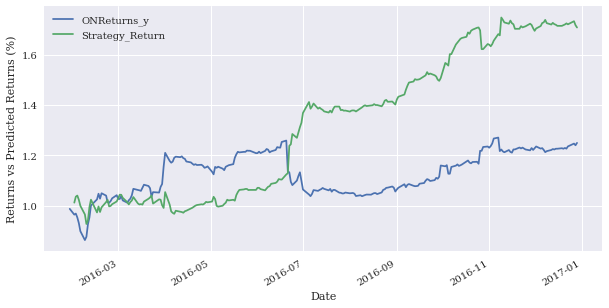

In [36]:
# Predicted Values
stock['Predicted_Values'] = model.predict(stock[features])

stock['Predicted_Values'] = np.where(asset['Predicted_Values'] > 0, 1, -1)
stock['Strategy_Return'] = stock['Predicted_Values'] * (stock['ONReturns_y'].shift(1))

# Calculate geometric returns under buy and hold strategy under real and predicted returns
geometric_returns = (stock.ONReturns_y.iloc[:]+1).cumprod()
geometric_returns_pred = (stock.Strategy_Return.iloc[:]+1).cumprod()
# Plot geometric returns
geometric_returns.plot(figsize=(10,5))
geometric_returns_pred.plot()

plt.ylabel("Returns vs Predicted Returns (%)")
plt.xlabel("Date")
plt.legend()
plt.show()

In [37]:
import pyfolio as pf

Start date,2016-01-29
End date,2016-12-29
Total months,11
,Backtest
Annual return,78.4%
Cumulative returns,70.8%
Annual volatility,23.5%
Sharpe ratio,2.59
Calmar ratio,7.22
Stability,0.93
Max drawdown,-10.9%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,10.86,2016-02-03,2016-02-09,2016-03-02,21
1,8.18,2016-04-01,2016-04-07,2016-05-19,35
2,5.04,2016-10-25,2016-10-28,2016-11-09,12
3,5.03,2016-03-02,2016-03-31,2016-04-01,23
4,3.02,2016-11-09,2016-12-01,NaT,NaN


Stress Events,mean,min,max
New Normal,0.24%,-4.95%,9.62%


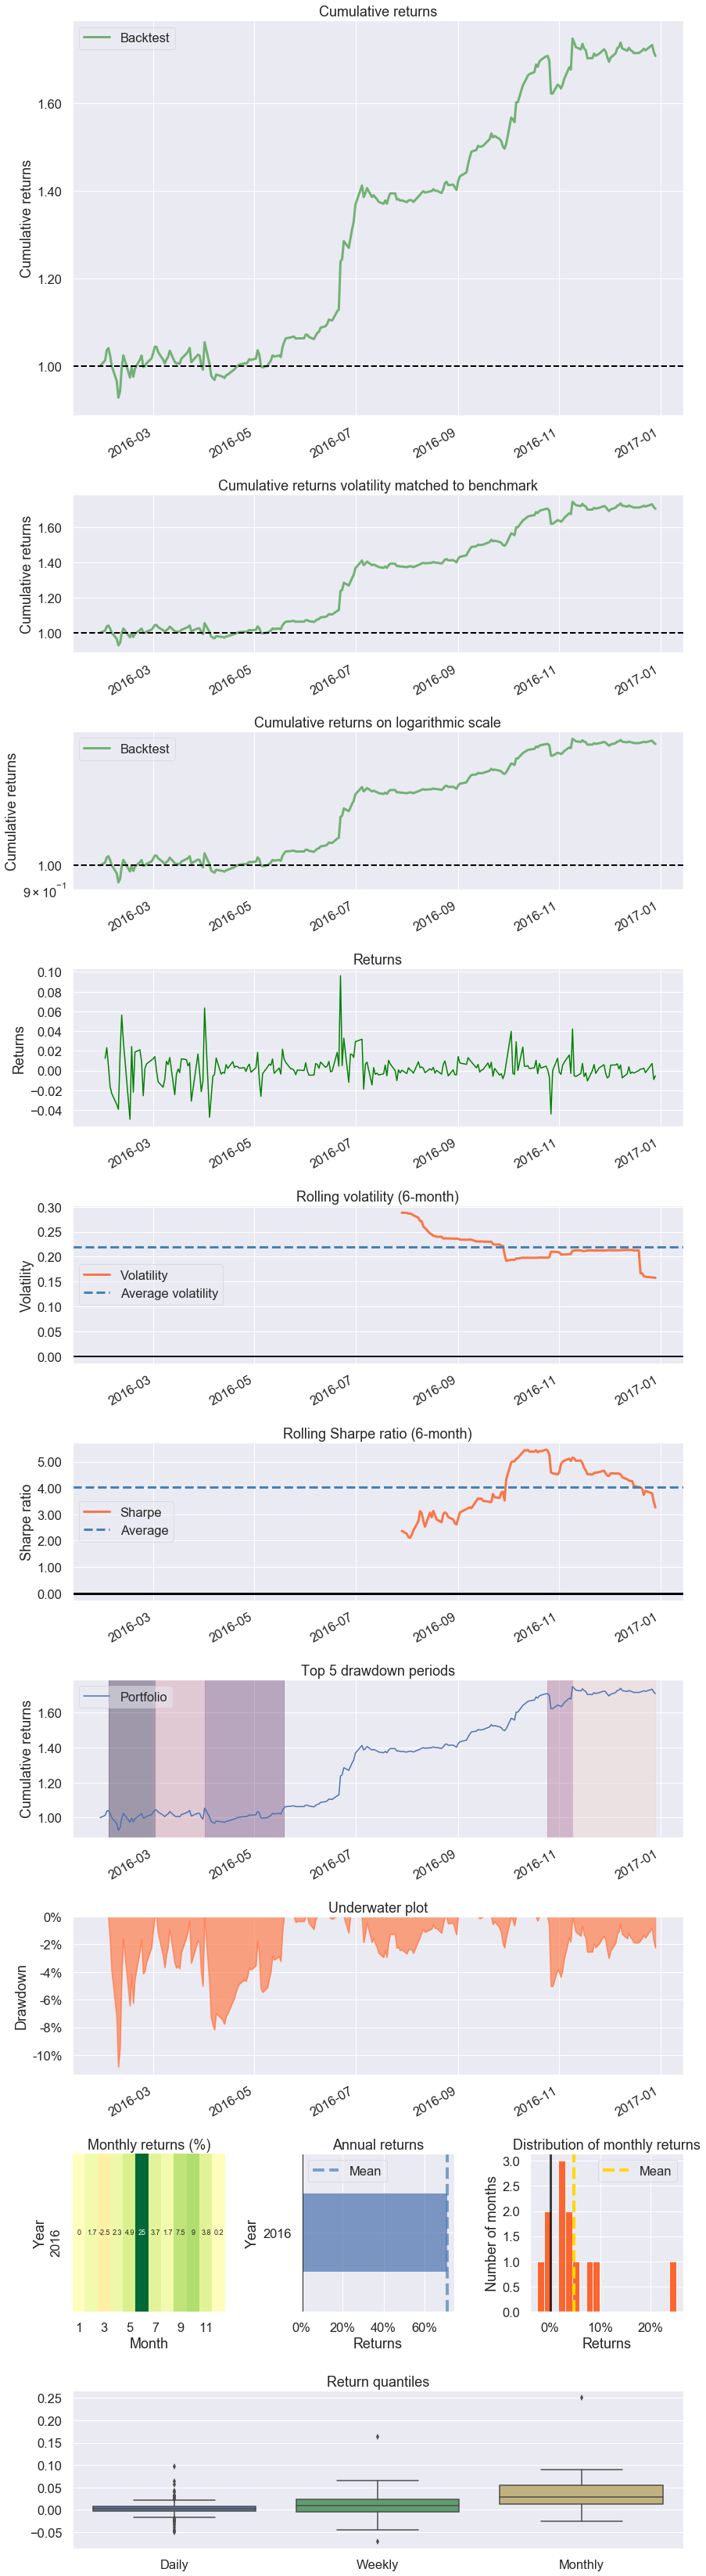

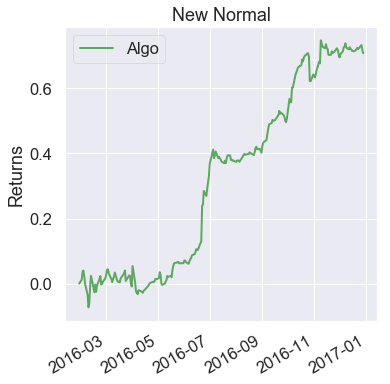

In [38]:
pf.create_full_tear_sheet(stock.Strategy_Return)

Start date,2016-01-29
End date,2016-12-29
Total months,11
,Backtest
Annual return,27.2%
Cumulative returns,25.0%
Annual volatility,23.7%
Sharpe ratio,1.13
Calmar ratio,1.55
Stability,0.30
Max drawdown,-17.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.55,2016-06-20,2016-08-09,2016-11-04,100
1,12.54,2016-01-29,2016-02-08,2016-02-12,11
2,7.04,2016-04-01,2016-05-03,2016-05-19,35
3,4.71,2016-11-07,2016-11-16,NaT,NaN
4,4.33,2016-03-18,2016-03-23,2016-03-30,9


Stress Events,mean,min,max
New Normal,0.11%,-9.62%,6.35%


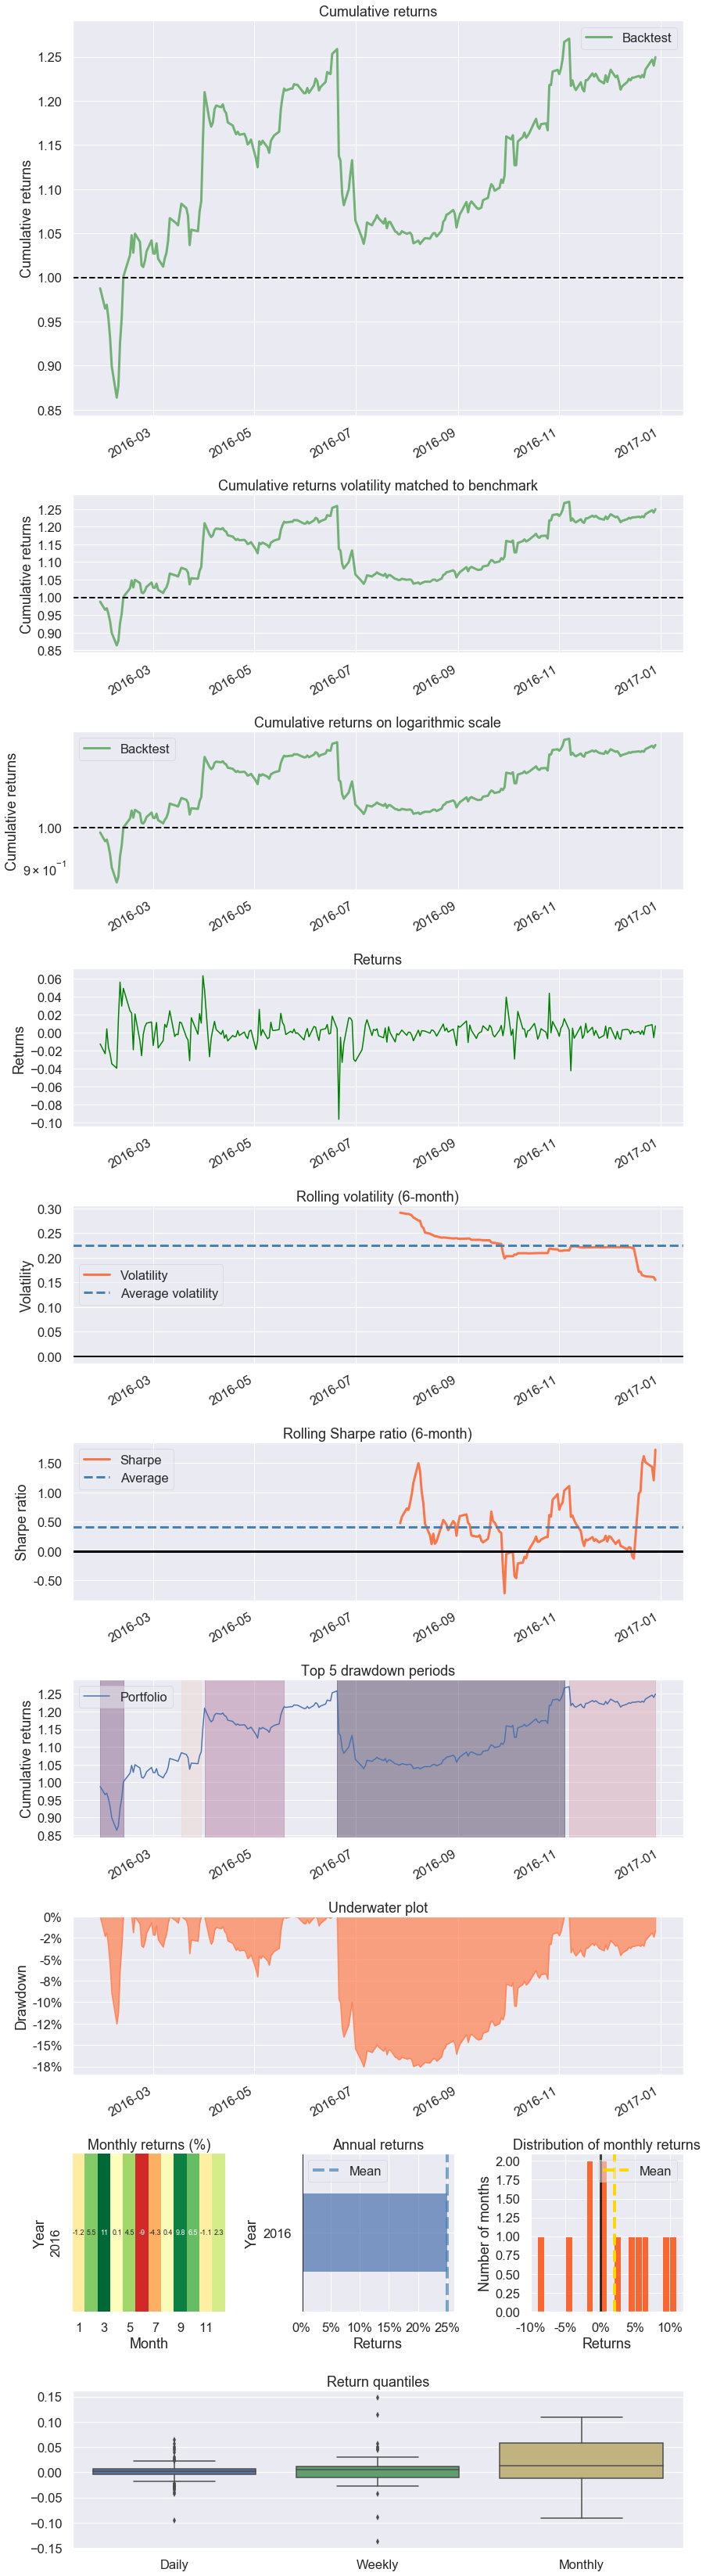

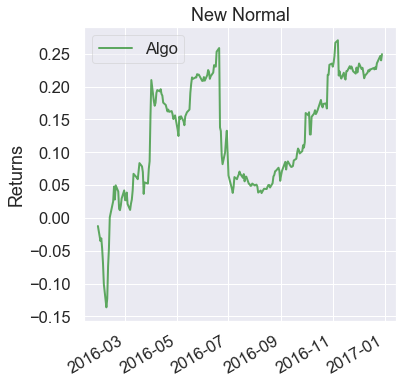

In [39]:
pf.create_full_tear_sheet(stock.ONReturns_y)